In [104]:
import pandas as pd
import numpy as np
from scipy import stats 
from scipy.stats import zscore

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly

import seaborn as sns

import ipywidgets

import json
import os
import sys
import io
import datetime

# Start by mapping 'games' data in original raw format into dataframe
Manually extracting the data from the website has the data in a 1 column list repeating every 4 rows.
1. Date
2. (team a) vs (Team b) - in Home vs Away order
3. (score) to (score)
4. game_id



In [109]:
#df_games = pd.DataFrame(columns = ['GAME_ID', 'DATE', 'SCORE_STR', 'TEAMS_STR'])
df_games = pd.DataFrame(columns = ['GAME_ID', 'DATE', 'SCORE_STR', 'TEAMS_STR', 'TOWN_TEAM_HOME', 'TOWN_TEAM_AWAY', 'GOALS_HOME', 'GOALS_AWAY', 'PTS_HOME', 'PTS_AWAY'])
df_games

#Duplicate 2x - organize by team as the key (independent of home vs away)
df_games_team = pd.DataFrame(columns = ['TOWN_TEAM', 'GAME_ID', 'DATE', 'SEASON', 'IsHome', 'TOWN_TEAM_OPPONENT', 'GOALS_FOR', 'GOALS_AGAINST', 'PTS'])


fp_games = ['../data/Grade 6 Girls Soccer - G6G_FALL2022_SCORES_RAW.csv', 
            '../data/Grade 6 Girls Soccer - G6G_SPRING2022_SCORES_RAW.csv']

for fp in fp_games:
    print(fp)
    file1 = open(fp, 'r')
    lines = file1.readlines()

    count = 0
    # Strips the newline character
    for line in lines:
        count += 1
        lineStr = line.strip()
        #print(lineStr)
        
        if (count % 4) == 1:
            d_dateStr = lineStr
            #print(d_dateStr)
            d_date = datetime.datetime.strptime(d_dateStr, '%m/%d/%Y')
            #d_date = d_dateStr
            
        elif (count % 4) == 2:
            d_teams = lineStr
            teamsArr = d_teams.split('vs.')
            d_team_home = teamsArr[0].strip()
            d_team_away = teamsArr[1].strip()
            
        elif (count % 4) == 3:
            d_scores = lineStr
            #win = 3, tie = 1, loss = 0. Forfeit (-3 forfeiting team, 0 other); double forfeit (both -3).
            if ('forfeit' not in d_scores.lower()):
                goalsArr = d_scores.split('to')
                d_goals_home = int(goalsArr[0])
                d_goals_away = int(goalsArr[1])
                
                if (d_goals_home == d_goals_away):
                    d_pts_home = 1
                    d_pts_away = 1
                elif (d_goals_home > d_goals_away):
                    d_pts_home = 3
                    d_pts_away = 0
                else:
                    d_pts_home = 0
                    d_pts_away = 3
                    
            elif ('away forfeit' in d_scores.lower()):
                d_pts_home = 0
                d_pts_away = -3
            elif ('home forfeit' in d_scores.lower()):
                d_pts_home = -3
                d_pts_away = 0
            elif ('double forfeit' in d_scores.lower()):
                d_pts_home = -3
                d_pts_away = -3
            else:
                print(f'SCORE ERROR({count}): {d_scores}')
            
            
        elif (count % 4) == 0:
            d_gameid = lineStr
            #df_games.append({'GAME_ID' : d_gameid, 'DATE' : d_date, 'SCORE_STR' : d_scores, 'TEAMS_STR' : d_teams}, ignore_index = True) 
            df_games.loc[len(df_games.index)] = [d_gameid, d_date, d_scores, d_teams, d_team_home, d_team_away, d_goals_home, d_goals_away, d_pts_home, d_pts_away]
            
            #['TOWN_TEAM', 'GAME_ID', 'DATE', 'SEASON', 'IsHome', 'TOWN_TEAM_OPPONENT', 'GOALS_FOR', 'GOALS_AGAINST', 'PTS']
            df_games_team.loc[len(df_games_team.index)] = [d_team_home, d_gameid, d_date, 0.0, True, d_team_away, d_goals_home, d_goals_away, d_pts_home]
            df_games_team.loc[len(df_games_team.index)] = [d_team_away, d_gameid, d_date, 0.0, False, d_team_home, d_goals_away, d_goals_home, d_pts_away]
        
    file1.close()

# Convert dataframe columns to desired types
#df_games['DATE']= pd.to_datetime(df_games['DATE'])
df_games['DATE'] = df_games['DATE'].astype('datetime64[ns]')
df_games['GOALS_HOME'] = df_games['GOALS_HOME'].astype('int')
df_games['GOALS_AWAY'] = df_games['GOALS_AWAY'].astype('int')
df_games['PTS_HOME'] = df_games['PTS_HOME'].astype('int')
df_games['PTS_AWAY'] = df_games['PTS_AWAY'].astype('int')




# Map date to determine spring vs fall and create numeric representation for first half spring vs second half fall.
#df_games['YEAR_HALF'] = df_games.apply(lambda x: x.timetuple().tm_yday)
#df_games['YEAR_HALF'] = df['date'].dt.year + df['date'].dt.month.gt(6).add(1).astype(str)
df_games['SEASON'] = np.where(df_games['DATE'].dt.month.le(6), df_games['DATE'].dt.year + 0, df_games['DATE'].dt.year + 0.5)
df_games_team['SEASON'] = np.where(df_games_team['DATE'].dt.month.le(6), df_games_team['DATE'].dt.year + 0, df_games_team['DATE'].dt.year + 0.5)


df_games
print(f"{df_games.shape} games initial single per-game version")

df_games_team
print(f"{df_games_team.shape} after initial processing")


../data/Grade 6 Girls Soccer - G6G_FALL2022_SCORES_RAW.csv
../data/Grade 6 Girls Soccer - G6G_SPRING2022_SCORES_RAW.csv
(1450, 11) games initial single per-game version
(2900, 9) after initial processing


In [106]:
# Extract Division from GAME_ID header
#[0]: optional, S=spring, F=fall
#[1]: optional, YY
#[2]: G for Grade
#[3]: grade number
#[4]: G for girls, B for boys
#[5..'-']: Division id
#['-'...]: game number
#str.fullmatch("", case=False)

#df_temp = df_games['GAME_ID'].str.extract(r'(?P<SEASON_IDX>(\w\d\d)?)(?P<GRADE>\w\d)(?P<GENDER>\w)(?P<DIVISION>\w\d\w\d)')
df_temp = df_games_team['GAME_ID'].str.extract(r'(?P<SEASON_IDX>(\w\d\d)?)G(?P<GRADE>\d)(?P<GENDER>\w)(?P<DIVISION>\w\d\w\d)-(?P<GAME_IDX>\d\d\d\d\d)')
df_temp['GRADE'] = df_temp['GRADE'].astype('int')
df_temp['GAME_IDX'] = df_temp['GAME_IDX'].astype('int')
#df_temp.value_counts()
#print(df_temp.info())
#df_temp.describe()
#print(df_temp['DIVISION'].unique())
df_temp

df_games_team[['SEASON_IDX','GRADE','GENDER','DIVISION','GAME_IDX']] = df_temp[['SEASON_IDX','GRADE','GENDER','DIVISION','GAME_IDX']]
df_games_team
print(f"{df_games_team.shape} after splitting GAME_ID")

df_divisions = pd.read_csv('../data/divisions.csv', header=0, names=['DIVISION_RANK','DIVISION'])
df_divisions

df_games_team = pd.merge(left=df_games_team, right=df_divisions, on='DIVISION', how='left').reset_index()
df_games_team
print(f"{df_games_team.shape} after merging divisions")

df_games_team['DIVISION_WITH_RANK'] = df_games_team.apply(lambda row: f"{row['DIVISION_RANK']}-{row['DIVISION']}", axis=1)
df_games_team
print(f"{df_games_team.shape} after creating division_rank")

#print(df_games_team[['SEASON','SEASON_IDX','GRADE','GENDER','DIVISION']].value_counts())
#print(df_games_team[['SEASON']].value_counts())
#print(df_games_team[['SEASON']].value_counts().sum())
#print(df_games_team.shape)
#print(df_games_team[['SEASON_IDX']].value_counts())
#print(df_games_team[['GRADE']].value_counts())
#print(df_games_team[['GENDER']].value_counts())
#print(df_games_team[['DIVISION']].value_counts())

#df_games_team
#df_games_team.info()

(2900, 14) after splitting GAME_ID
(2900, 16) after merging divisions
(2900, 17) after creating division_rank


In [107]:
# Process string of <town> <team> into columns
uh = df_games['TOWN_TEAM_HOME'].unique()
df_teams = pd.DataFrame({'TOWN_TEAM' : uh})
df_teams = df_teams.sort_values(by='TOWN_TEAM')
#df_teams['TOWN_TEAM'].to_csv('../data/teams_export.csv', index=False)

# Add mapping of town to teams
df_towns = pd.read_csv('../data/towns.csv', header=None, names=['TOWN'])
df_towns = df_towns.sort_values(by='TOWN', key=lambda x: x.str.len(), ascending=False)
df_towns
for town in df_towns['TOWN']:
    i = len(town)
    #print(i, town)
    mask = df_teams['TOWN_TEAM'].str.startswith(town)
    df_teams.loc[mask, 'TOWN'] = town
    df_teams.loc[mask, 'TEAM'] = df_teams.TOWN_TEAM.apply(lambda x: x[i:])

df_teams.to_csv('../data/teams_export.csv', index=False)

df_teams


,TOWN_TEAM,TOWN,TEAM
102,Amesbury Gators,Amesbury,Gators
67,Amesbury STORM,Amesbury,STORM
127,Amesbury Storm,Amesbury,Storm
14,Andover Akers,Andover,Akers
86,Andover Arsenal,Andover,Arsenal
...,...,...,...
114,Winthrop Seasiders,Winthrop,Seasiders
82,Winthrop Waves,Winthrop,Waves
51,Woburn Cobras,Woburn,Cobras
20,Woburn Inferno,Woburn,Inferno


In [108]:
# Split Town and Team from each home and away

df_games_team = pd.merge(left=df_games_team, right=df_teams, on='TOWN_TEAM', how='left')
df_games_team = pd.merge(left=df_games_team, right=df_teams, left_on='TOWN_TEAM_OPPONENT', right_on='TOWN_TEAM', how='left', suffixes=('','_OPPONENT'))

print(f"{df_games_team.shape} after splitting town teams home and away")
df_games_team.info()
print(df_games_team[(df_games_team['TOWN_TEAM'] == 'Andover Morgan') & (df_games_team['SEASON'] == 2022.5)])

(2900, 22) after splitting town teams home and away
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 2899
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               2900 non-null   int64         
 1   TOWN_TEAM           2900 non-null   object        
 2   GAME_ID             2900 non-null   object        
 3   DATE                2900 non-null   datetime64[ns]
 4   SEASON              2900 non-null   float64       
 5   IsHome              2900 non-null   bool          
 6   TOWN_TEAM_OPPONENT  2900 non-null   object        
 7   GOALS_FOR           2900 non-null   int64         
 8   GOALS_AGAINST       2900 non-null   int64         
 9   PTS                 2900 non-null   int64         
 10  SEASON_IDX          2900 non-null   object        
 11  GRADE               2900 non-null   int64         
 12  GENDER              2900 non-null   object        
 

# Teams Distribution

TOWN_TEAM    141
TOWN         140
TEAM         140
dtype: int64
                TOWN  TEAM
0            Andover    15
1          Topsfield    10
2               Lynn     9
3    Hamilton-Wenham     9
4      North Andover     8
5         Marblehead     6
6            Danvers     6
7      North Reading     6
8         Georgetown     6
9        Newburyport     5
10         Wakefield     5
11           Ipswich     5
12           Beverly     5
13            Triton     4
14           Methuen     4
15            Dracut     4
16           Peabody     4
17        Swampscott     4
18             Salem     3
19          Winthrop     3
20          Amesbury     3
21         Pentucket     3
22            Woburn     3
23            Saugus     2
24            Revere     2
25  Manchester-Essex     2
26         Haverhill     2
27          Rockport     1
28          Lawrence     1


<AxesSubplot: xlabel='TEAM', ylabel='TOWN'>

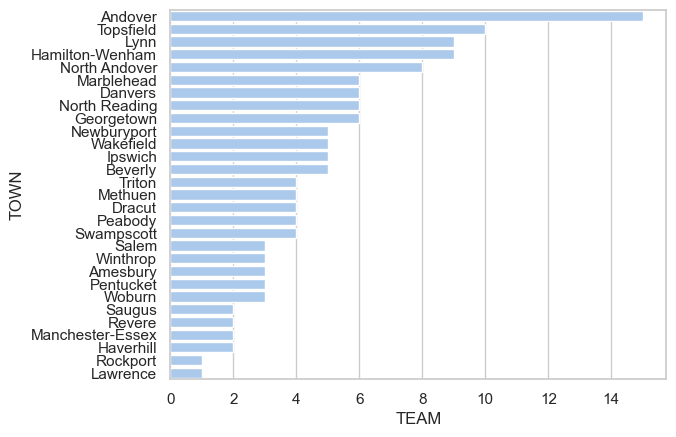

In [87]:
g = df_teams[['TOWN','TEAM']].groupby(by='TOWN').count().sort_values(by='TEAM', ascending=False)
g.reset_index(inplace=True)
print(df_teams.count())
print(g)
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x="TEAM", y="TOWN", data=g, label="NumTeams", color="b")

# Create standading dataframe per-season

     SEASON  DIVISION_RANK DIVISION                  TOWN_TEAM     TOWN  \
5    2022.5             14     M1G1               Andover Dunn  Andover   
17   2022.5             12     M1G3              Andover Akers  Andover   
33   2022.5             10     M2G2            Andover Lavelle  Andover   
41   2022.5              9     M2G3           Andover Chastain  Andover   
48   2022.5              8     M2G4             Andover Morgan  Andover   
54   2022.5              7     C1G1            Andover Fawcett  Andover   
66   2022.5              5     C1G3             Andover O'Hara  Andover   
75   2022.5              4     C1G4              Andover Foudy  Andover   
83   2022.5              3     C1G5              Andover Press  Andover   
89   2022.0             14     M1G1            Andover Arsenal  Andover   
95   2022.0             13     M1G2               Andover Dunn  Andover   
120  2022.0              9     M2G3            Andover Everton  Andover   
129  2022.0              

<AxesSubplot: xlabel='DIVISION_RANK', ylabel='PTS'>

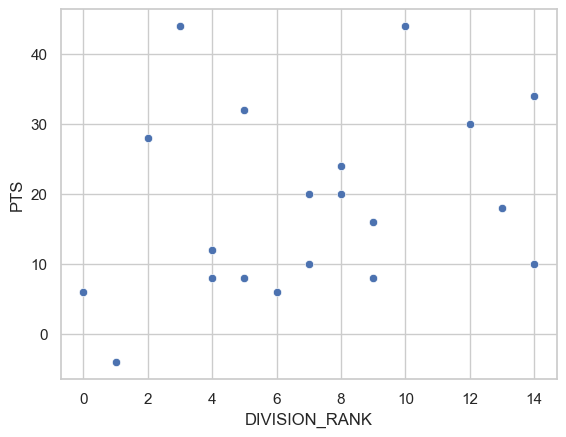

In [88]:
df_standings = pd.DataFrame(columns = ['SEASON', 'DIVISION', 'TEAM', 'TOWN', 'PTS', 'GOALS_FOR', 'GOALS_AGAINST'])
df_standings


#g1 = df_games_team.groupby(by=['SEASON','DIVISION_WITH_RANK','TOWN_TEAM', 'TOWN', 'TEAM'])[['PTS', 'GOALS_FOR', 'GOALS_AGAINST']]
g1 = df_games_team.groupby(by=['SEASON','DIVISION_RANK', 'DIVISION','TOWN_TEAM', 'TOWN', 'TEAM'])[['PTS', 'GOALS_FOR', 'GOALS_AGAINST']]
#g2 = g1.sum().sort_values(by='PTS', ascending=False)
g2 = g1.sum().sort_values(by='PTS', ascending=False)
g3 = g2.sort_index(ascending=False)
g4 = g3.reset_index()

g4

mask = g4['TOWN'] == 'Andover'
g5 = g4[mask].sort_values(by=['SEASON','DIVISION_RANK'], ascending=False)
print(g5)

sns.scatterplot(g5, x='DIVISION_RANK', y='PTS')


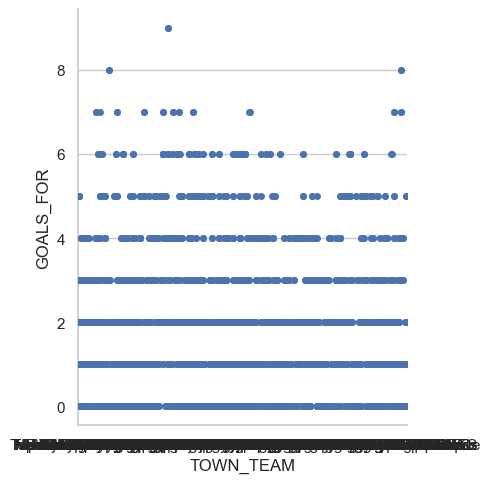

In [89]:
sns.catplot(data=df_games_team, x="TOWN_TEAM", y="GOALS_FOR")